In [1]:
# Install everything
!python -m pip install "dask[complete]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/291/1
INFO:distributed.scheduler:  dashboard at:            localhost:8787
INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/291/4
INFO:distributed.worker:         Listening to:          inproc172.28.0.12
INFO:distributed.worker:          Worker name:                          0
INFO:distributed.worker:         dashboard at:          172.28.0.12:40619
INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/291/1
INFO:distributed.worker:-------------------------------------------------
INFO:distributed.worker:              Threads:                          4
INFO:distributed.worker:               Memory:                   1.86 GiB
INFO:distributed.worker:      Local Directory: /tmp/dask-worker-space/worker-_d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.28.0.12:8787/status,
Dashboard: http://172.28.0.12:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://172.28.0.12/291/1,Workers: 1
Dashboard: http://172.28.0.12:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://172.28.0.12/291/4,Total threads: 4
Dashboard: http://172.28.0.12:40619/status,Memory: 1.86 GiB
Nanny: None,


In [3]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [4]:
X, y = make_classification(n_samples=1000, random_state=0)
X[:5]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644],
       [ 0.94028404, -0.49214582,  0.67795602, -0.22775445,  1.40175261,
         1.23165333, -0.77746425,  0.01561602,  1.33171299,  1.08477266,
        -0.97805157, -0.05012039,  0.94838552, -0.17342825, -0.47767184,
         0.76089649,  1.00115812, -0.06946407,  1.35904607, -1.18958963],
       [-0.29951677,  0.75988955,  0.18280267, -1.55023271,  0.33821802,
         0.36324148, -2.10052547, -0.4380675 , -

In [5]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)

In [6]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

In [7]:
pd.DataFrame(grid_search.cv_results_).head()
grid_search.predict(X)[:5]
grid_search.score(X, y)

0.983

In [8]:
%matplotlib inline

In [9]:
!pip install dask-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.5/148.5 KB 3.8 MB/s eta 0:00:00


In [10]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [11]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

In [12]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

/usr/local/lib/python3.9/dist-packages/dask/base.py:1367: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

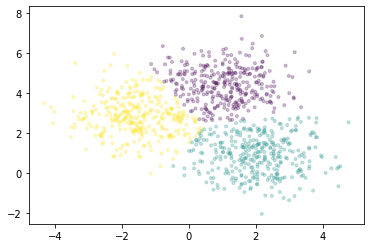

In [13]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);